### 一个使用DEEPONET的示例：
对于一个微分方程：
$$
\frac{ds}{dx} = -s^2 + u(x) , x \in (a,b)，  
S(0)=0
$$
输入数据： 一系列的$u(x_i)$,和观测点$y_i$,
输出数据：观测点$y_i$对应的S(y)的值，比较与实际值的损失，训练

作用：学习到微分的映射关系，同时也依赖于训练数据量u(x).

### 1.1网络构建与训练

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 1. 数据生成
def generate_data(num_samples=100, num_points=50):
    data_u = []
    data_s = []
    x = np.linspace(0, 1, num_points)  # Domain

    for _ in range(num_samples):
        u = np.sin(2 * np.pi * x * np.random.uniform(0.5, 4.0))  # Random input function u(x)
        s = [0]  # Initial condition s(0) = 0
        for i in range(1, len(x)):
            dx = x[i] - x[i - 1]
            ds_dx = -s[-1]**2 + u[i - 1]
            s.append(s[-1] + ds_dx * dx)  # Numerical solution
        data_u.append(u)
        data_s.append(s)

    return np.array(data_u), np.array(data_s), x    
'''
生成训练数据，还需要U(X),取样一个函数U_i(Y),生成对应Y下的解S(Y),
重复取样num_samples个函数U_n(Y)
'''
# Generate data
num_samples = 2000
num_points = 100
u_data, s_data, x_data = generate_data(num_samples, num_points)

# 2.网络构建
class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim):
        super(DeepONet, self).__init__()
        # Branch network for u(x)
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # Trunk network for x
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # Final output layer
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, u, x):
        branch_out = self.branch_net(u)
        trunk_out = self.trunk_net(x)
        combined = branch_out * trunk_out
        output = self.output_layer(combined)
        return output

# 超参数
branch_input_dim = num_points  # Number of sensors
trunk_input_dim = 1  # Single point x
hidden_dim = 50

# 定义模型
model = DeepONet(branch_input_dim, trunk_input_dim, hidden_dim)

# 3. 训练
# Prepare data for training
u_tensors = torch.tensor(u_data, dtype=torch.float32)
s_tensors = torch.tensor(s_data, dtype=torch.float32)
x_tensors = torch.tensor(x_data, dtype=torch.float32).view(-1, 1)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

'''# Training loop
epochs = 500
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(num_samples):
        u_sample = u_tensors[i].unsqueeze(0)  # Single u(x)
        s_sample = s_tensors[i].view(-1, 1)  # Corresponding s(x)
        x_sample = x_tensors  # x values

        # Forward pass
        outputs = model(u_sample, x_sample)
        loss = loss_fn(outputs, s_sample)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss / num_samples:.6f}")

# 4. Test DeepONet
# Generate a new random u(x)
test_u, test_s, test_x = generate_data(num_samples=1, num_points=num_points)
test_u_tensor = torch.tensor(test_u, dtype=torch.float32).unsqueeze(0)
test_x_tensor = torch.tensor(test_x, dtype=torch.float32).view(-1, 1)

# Predict
predicted_s = model(test_u_tensor, test_x_tensor).detach().numpy()

# Plot results
plt.plot(test_x, test_s[0], label="True Solution", linestyle='dashed')
plt.plot(test_x, predicted_s[0], label="DeepONet Prediction")
plt.legend()
plt.xlabel("x")
plt.ylabel("s(x)")
plt.title("DeepONet ODE Solution")
plt.show()'''


'# Training loop\nepochs = 500\nfor epoch in range(epochs):\n    epoch_loss = 0\n    for i in range(num_samples):\n        u_sample = u_tensors[i].unsqueeze(0)  # Single u(x)\n        s_sample = s_tensors[i].view(-1, 1)  # Corresponding s(x)\n        x_sample = x_tensors  # x values\n\n        # Forward pass\n        outputs = model(u_sample, x_sample)\n        loss = loss_fn(outputs, s_sample)\n\n        # Backward pass\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        epoch_loss += loss.item()\n    if epoch % 100 == 0:\n        print(f"Epoch {epoch}, Loss: {epoch_loss / num_samples:.6f}")\n\n# 4. Test DeepONet\n# Generate a new random u(x)\ntest_u, test_s, test_x = generate_data(num_samples=1, num_points=num_points)\ntest_u_tensor = torch.tensor(test_u, dtype=torch.float32).unsqueeze(0)\ntest_x_tensor = torch.tensor(test_x, dtype=torch.float32).view(-1, 1)\n\n# Predict\npredicted_s = model(test_u_tensor, test_x_tensor).detach().numpy()\n\n# 

### 1.2训练效果检验

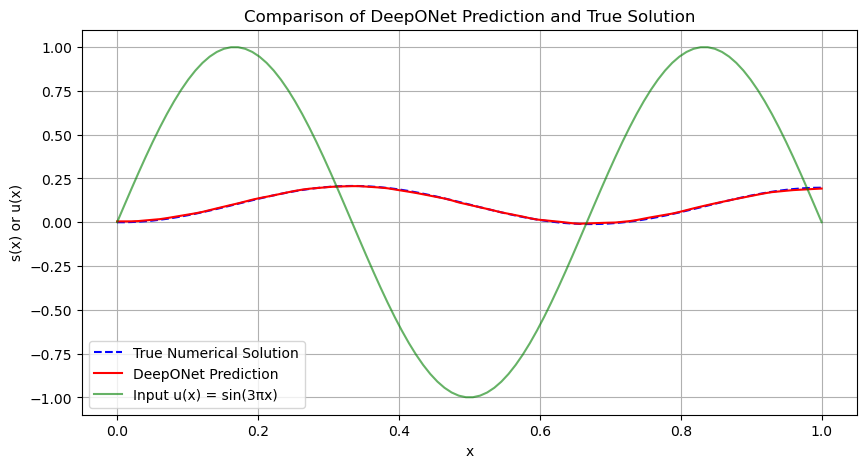

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 1. Define the ODE Solver for the True Numerical Result
def solve_ode_numerically(u, x):
    """
    Solve the ODE ds/dx = -s^2 + u(x) numerically using Euler's method.
    Args:
        u: Input function u(x) (numpy array).
        x: Spatial points (numpy array).
    Returns:
        s: Numerical solution s(x).
    """
    s = [0]  # Initial condition s(0) = 0
    for i in range(1, len(x)):
        dx = x[i] - x[i - 1]
        ds_dx = -s[-1]**2 + u[i - 1]
        s.append(s[-1] + ds_dx * dx)
    return np.array(s)

# 2. Define a Simple Test Function u(x)
x_test = np.linspace(0, 1, 100)  # Spatial points for testing
#u_test2 = np.sin( 5 * np.pi * x_test)  # Define u(x) = sin(2 * pi * x)
u_test = np.sin( 3 * np.pi * x_test)  # Define u(x) = sin(3 * pi * x)
# Solve the ODE numerically for the test input
true_s = solve_ode_numerically(u_test, x_test)

# 3. Predict s(x) Using DeepONet
# Prepare test tensors
test_u_tensor = torch.tensor(u_test, dtype=torch.float32).unsqueeze(0)  # Shape (1, 50)
test_x_tensor = torch.tensor(x_test, dtype=torch.float32).view(1, -1, 1)  # Shape (1, 50, 1)

# Predict with the trained model
model.eval()  # Set the model to evaluation mode
predicted_s = model(test_u_tensor, test_x_tensor).detach().numpy().flatten()  # Flatten for comparison

# 4. Plot and Compare Results
plt.figure(figsize=(10, 5))
plt.plot(x_test, true_s, label="True Numerical Solution", color="blue", linestyle="--")
plt.plot(x_test, predicted_s, label="DeepONet Prediction", color="red")
plt.plot(x_test, u_test, label="Input u(x) = sin(3πx)", color="green", alpha=0.6)
plt.xlabel("x")
plt.ylabel("s(x) or u(x)")
plt.title("Comparison of DeepONet Prediction and True Solution")
plt.legend()
plt.grid()
plt.show()


### 1.3参数保存

In [4]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 1. Define the ODE Solver for the True Numerical Result
def solve_ode_numerically(u, x):
    """
    Solve the ODE ds/dx = -s^2 + u(x) numerically using Euler's method.
    Args:
        u: Input function u(x) (numpy array).
        x: Spatial points (numpy array).
    Returns:
        s: Numerical solution s(x).
    """
    s = [0]  # Initial condition s(0) = 0
    for i in range(1, len(x)):
        dx = x[i] - x[i - 1]
        ds_dx = -s[-1]**2 + u[i - 1]
        s.append(s[-1] + ds_dx * dx)
    return np.array(s)

# 2. Define a Simple Test Function u(x)
x_test2 = np.linspace(0, 1, 100)  # Spatial points for testing
u_test2 = np.sin( 5 * np.pi * x_test2)  # Define u(x) = sin(2 * pi * x)
# Solve the ODE numerically for the test input
true_s2 = solve_ode_numerically(u_test2, x_test2)

# 3. Predict s(x) Using DeepONet
# Prepare test tensors
test_u_tensor2 = torch.tensor(u_test2, dtype=torch.float32).unsqueeze(0)  # Shape (1, 50)
test_x_tensor2 = torch.tensor(x_test2, dtype=torch.float32).view(1, -1, 1)  # Shape (1, 50, 1)

# Predict with the trained model
model.eval()  # Set the model to evaluation mode
predicted_s2 = model(test_u_tensor2, test_x_tensor2).detach().numpy().flatten()  # Flatten for comparison

# 4. Plot and Compare Results
plt.figure(figsize=(10, 5))
plt.plot(x_test2, true_s2, label="True Numerical Solution", color="blue", linestyle="--")
plt.plot(x_test2, predicted_s2, label="DeepONet Prediction", color="red")
plt.plot(x_test2, u_test2, label="Input u(x) = sin(5πx)", color="green", alpha=0.6)
plt.xlabel("x")
plt.xlabel("x")
plt.ylabel("s(x)")
plt.title("Comparison of DeepONet Prediction and True Solution")
plt.legend()
plt.grid()
plt.show()


## 观察图像效果，发现超出数据集外的函数，效果好像并不是很好

## 2.尝试利用训练的网络逆向求解
1.训练网络
2.保存参数
3.逆向求解

### 2.1载入参数，逆向求解
#### 2.1.1 确定目标函数，构造数据集，
考虑到这个简单的网络的训练使用的是sine函数，且根据输出结果的观察，为类SIN函数，不妨设需要的输出结果为0.12sin(3(x-pi/2))+0.12,根据网络结构，选定100个观测带点。

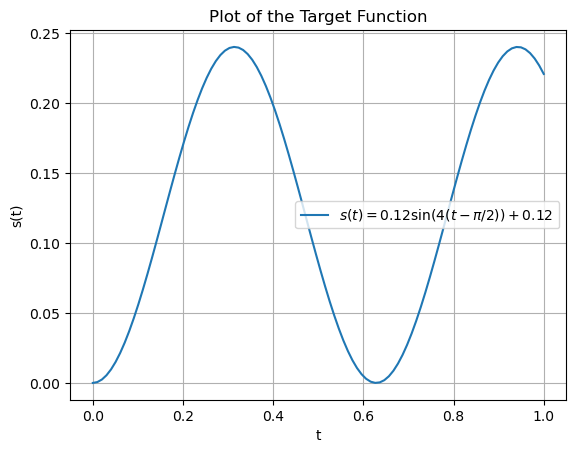

In [5]:
#生成目标数据
import numpy as np
import matplotlib.pyplot as plt

# Define the range for t
t = np.linspace(0, 1, 100)

# Define the target function
s_target = 0.12 * np.sin(10* (t - np.pi / (2*10))) + 0.12

#print(s_target)

# Plot the function
plt.plot(t, s_target, label=r"$s(t) = 0.12\sin(4(t - \pi/2)) + 0.12$")
plt.xlabel("t")
plt.ylabel("s(t)")
plt.title("Plot of the Target Function")
plt.grid(True)
plt.legend()
plt.show()


In [1]:
import numpy as np
import torch
import torch.nn as nn

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim):
        super(DeepONet, self).__init__()
        # Branch network for u(x)
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # Trunk network for x
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # Final output layer
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, u, x):
        branch_out = self.branch_net(u)
        trunk_out = self.trunk_net(x)
        combined = branch_out * trunk_out
        output = self.output_layer(combined)
        return output
    
branch_input_dim = 100  # Number of sensors
trunk_input_dim = 1  # Single point x
hidden_dim = 50

model = DeepONet(branch_input_dim, trunk_input_dim, hidden_dim)
model.load_state_dict(torch.load('model.pth'))


C:\Users\19464\AppData\Local\Temp\ipykernel_17296\3267596387.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

tensor([0.6362, 0.6135, 0.3217, 0.5555, 0.3855, 0.0139, 0.9707, 0.0288, 0.9864,
        0.3397, 0.0640, 0.7602, 0.5540, 0.4834, 0.3104, 0.8454, 0.5817, 0.8982,
        0.8236, 0.5019, 0.5900, 0.4054, 0.4162, 0.4038, 0.4536, 0.5531, 0.6410,
        0.6482, 0.6915, 0.9430, 0.2502, 0.0780, 0.9178, 0.1623, 0.5019, 0.1390,
        0.9772, 0.7436, 0.5231, 0.1932, 0.4266, 0.4852, 0.5292, 0.0134, 0.4170,
        0.4999, 0.5697, 0.7938, 0.7259, 0.7327, 0.8659, 0.0430, 0.3784, 0.3037,
        0.6672, 0.9713, 0.2660, 0.3687, 0.9404, 0.6638, 0.0988, 0.0514, 0.1070,
        0.4895, 0.3700, 0.1787, 0.1618, 0.0145, 0.8008, 0.9538, 0.8653, 0.2099,
        0.8061, 0.1495, 0.9073, 0.0542, 0.1852, 0.7457, 0.1115, 0.5425, 0.0147,
        0.1362, 0.8309, 0.5152, 0.3619, 0.1456, 0.6727, 0.7142, 0.3131, 0.6958,
        0.9088, 0.5820, 0.3471, 0.5776, 0.4935, 0.1086, 0.6580, 0.5344, 0.2105,
        0.5846], requires_grad=True)
Epoch 0, Loss: 0.026499
Epoch 100, Loss: 0.016350
Epoch 200, Loss: 0.011124
Epoch 3

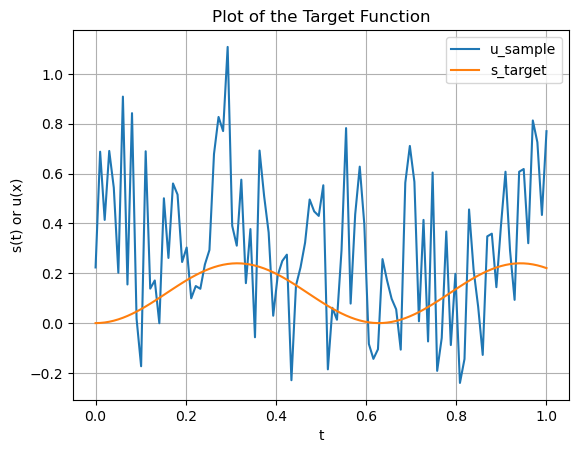

In [25]:
u_sample = torch.rand(100,requires_grad=True)
t_target = torch.tensor(t,dtype=torch.float32).view(-1,1)
s_target1 = torch.tensor(s_target,dtype=torch.float32)
print(u_sample)

for param in model.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam([u_sample], lr=0.001,weight_decay=1e-4)
loss_fn = nn.MSELoss()

epochs = 1000
for epoch in range(epochs):
    # Forward pass
    outputs = model(u_sample, t_target)
    loss = loss_fn(outputs, s_target1)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")

plt.plot(t_target.numpy(), u_sample.detach().numpy())  # 转换为 NumPy 数组
plt.plot(t_target.numpy(), s_target1.numpy())  # 同样转换为 NumPy 数组
plt.xlabel("t")
plt.ylabel("s(t) or u(x)")
plt.title("Plot of the Target Function")
plt.grid(True)
plt.legend(["u_sample", "s_target"])
plt.show()

### 根据逆向求解的情况来看，不出意外的出现了数据为散点的情况，因为本质上是点到点的映射，所以在逆向映射过程中，并不会考虑到连续性问题，尤其是与时间的对应关系。
#### 或许可能的办法：
##### 1.是否有什么方法，将时间值与数据值重组，形成一个连续的函数？
##### 2.是否能够对网络进行改进，将其与时间关联起来，使其自然而然地生成为函数的时间对应值，而非随机的散点。×
##### 3.是否能够拟合点为函数，再重新取点放入模型评估，若不行，则重新优化，如此迭代。